# Azure LLM inference traces
The trace description can be found [here](https://github.com/Azure/AzurePublicDataset/blob/master/AzureLLMInferenceDataset2024.md).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
TRACE_NAMES = [
    "Coding",
    "Conversation",
]

In [3]:
TRACE_FILENAMES = [
    "/home/user/projects/AzurePublicDataset/data/AzureLLMInferenceTrace_code_1week_nomicro.csv",
    "/home/user/projects/AzurePublicDataset/data/AzureLLMInferenceTrace_conv_1week_nomicro.csv",
]

In [6]:
# # Read all traces
# df_traces = {}
# for trace_name, trace_filename in zip(TRACE_NAMES, TRACE_FILENAMES):
#     # We need to use mixed format because we have both:
#     # 2024-05-12 00:00:00.001163+00:00 and 2024-05-12 00:00:00+00:00
#     # This is pretty expensive and there are probably better ways to handle this
#     df_traces[trace_name] = pd.read_csv(trace_filename, parse_dates=["TIMESTAMP"], date_format="mixed", dayfirst=False)

# for trace_name, trace_filename in zip(TRACE_NAMES, TRACE_FILENAMES):
df_traces = {}
for name, filename in zip(TRACE_NAMES, TRACE_FILENAMES):
    # 使用明确的格式，避免 date_format="mixed" 的开销
    print("processing: ", filename)
    df_traces[name] = pd.read_csv(
        filename, 
        parse_dates=["TIMESTAMP"], 
        date_format='%Y-%m-%d %H:%M:%S%z', # 这是优化后的关键
    )
    print("done")

processing:  /home/user/projects/AzurePublicDataset/data/AzureLLMInferenceTrace_code_1week_nomicro.csv
done
processing:  /home/user/projects/AzurePublicDataset/data/AzureLLMInferenceTrace_conv_1week_nomicro.csv
done


In [7]:
df_traces["Coding"]

,TIMESTAMP,ContextTokens,GeneratedTokens
0,2024-05-10 00:00:00+00:00,2399,6
1,2024-05-10 00:00:00+00:00,76,15
2,2024-05-10 00:00:00+00:00,2376,1
3,2024-05-10 00:00:00+00:00,7670,8
4,2024-05-10 00:00:00+00:00,6385,1
...,...,...,...
16803656,2024-05-16 23:59:59+00:00,897,1
16803657,2024-05-16 23:59:59+00:00,2842,79
16803658,2024-05-16 23:59:59+00:00,378,56
16803659,2024-05-16 23:59:59+00:00,491,1


In [8]:
df_traces["Conversation"]

,TIMESTAMP,ContextTokens,GeneratedTokens
0,2024-05-12 00:00:00+00:00,584,3
1,2024-05-12 00:00:00+00:00,862,38
2,2024-05-12 00:00:00+00:00,1569,3
3,2024-05-12 00:00:00+00:00,617,104
4,2024-05-12 00:00:00+00:00,550,20
...,...,...,...
27303939,2024-05-18 23:59:59+00:00,1224,11
27303940,2024-05-18 23:59:59+00:00,283,56
27303941,2024-05-18 23:59:59+00:00,336,8
27303942,2024-05-18 23:59:59+00:00,3152,264


Coding


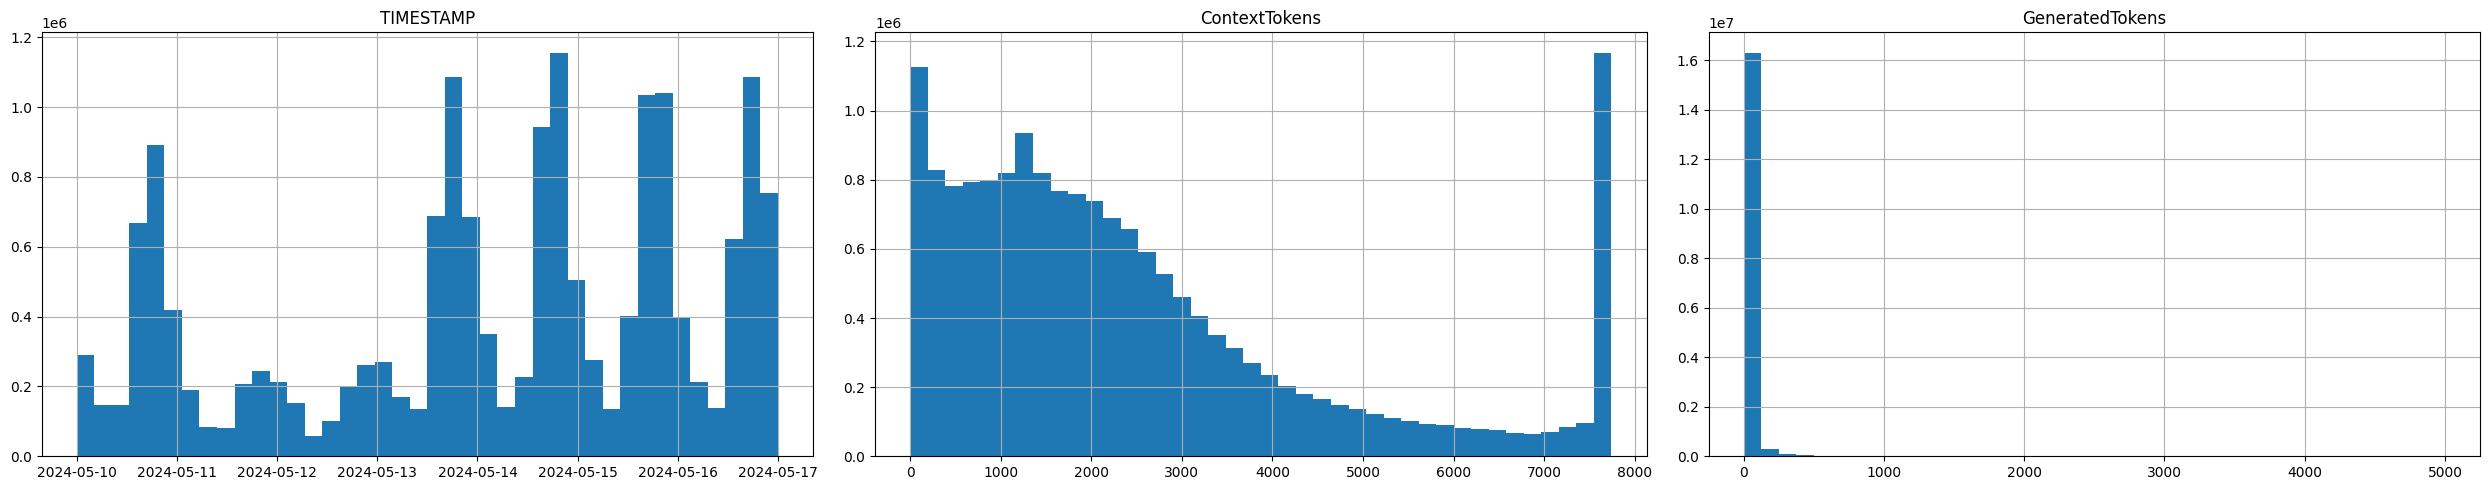

Conversation


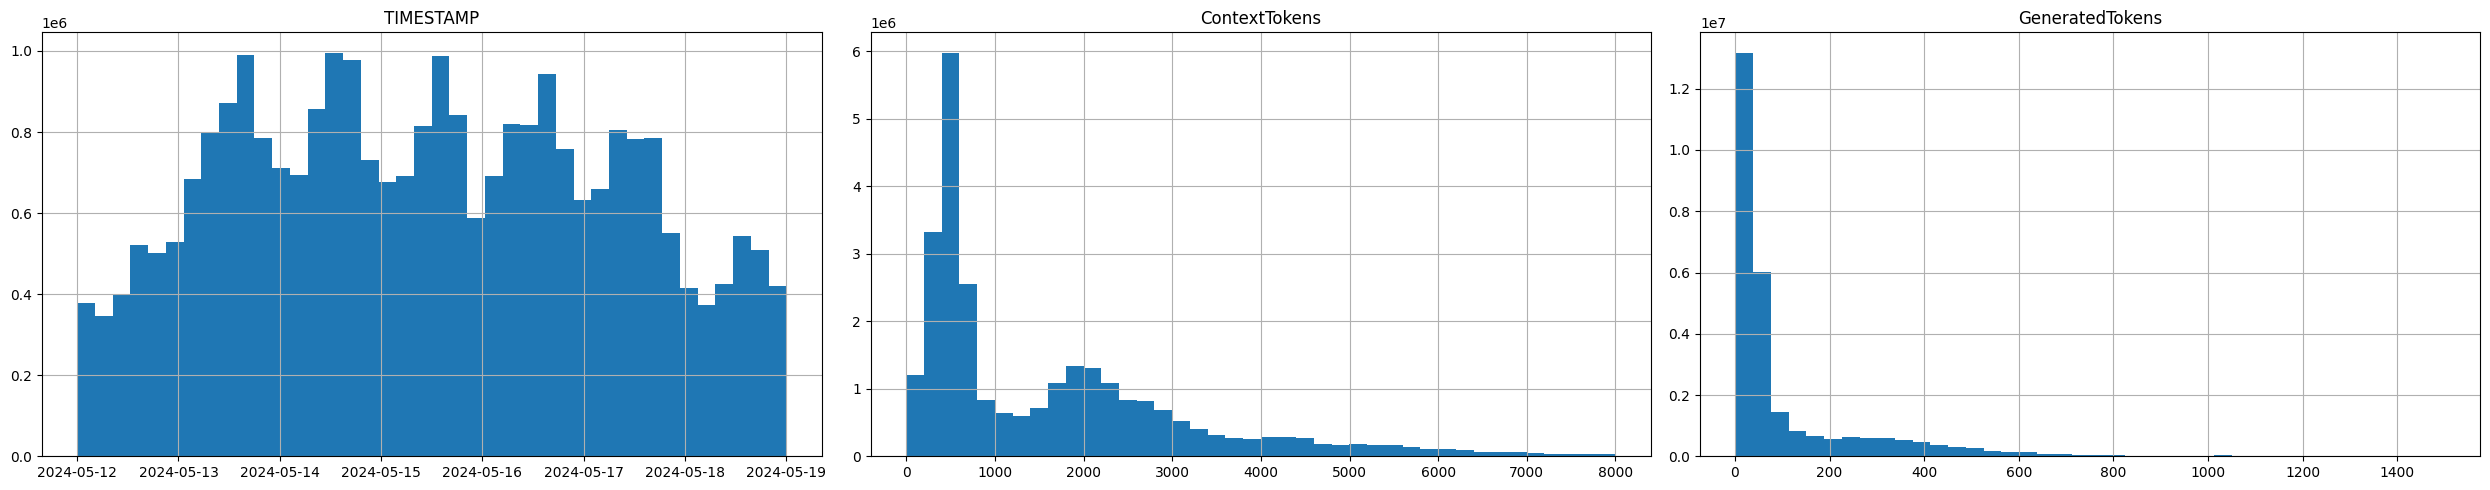

In [9]:
for trace_name, df_trace in df_traces.items():
    print(trace_name)
    df_trace.hist(
        layout=(1, 3),
        figsize=(25, 5),
        bins=40,
    )
    plt.tight_layout()
    plt.show()

## Token distributions

In [10]:
def get_cdf(df, field):
    vals = sorted(df[field].values)
    invs = 100.0 * np.arange(0, len(df)) / len(df)
    return vals, invs

In [11]:
def plt_tokens(dfs, field="ContextTokens", title="Input Tokens"):
    for df_key, df in dfs.items():
        df_tokens, df_inv = get_cdf(df, field)
        plt.plot(df_tokens, df_inv, label=df_key)
    plt.title(title)
    plt.ylabel("CDF")
    plt.xlabel("Number of tokens")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

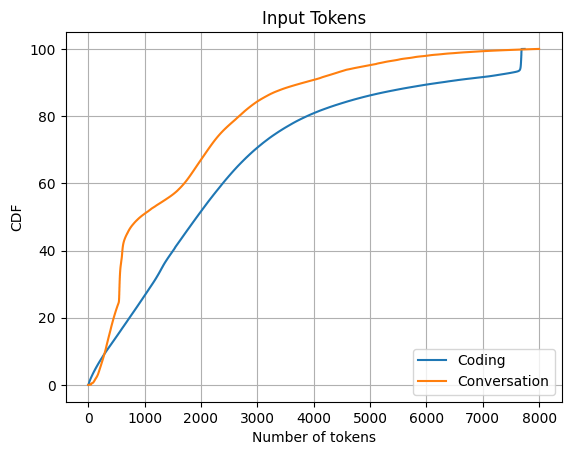

In [12]:
plt_tokens(df_traces, "ContextTokens", "Input Tokens")

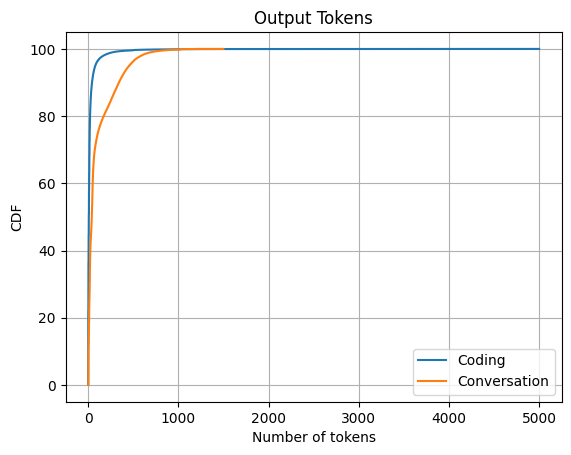

In [13]:
plt_tokens(df_traces, "GeneratedTokens", "Output Tokens")

## Correlation

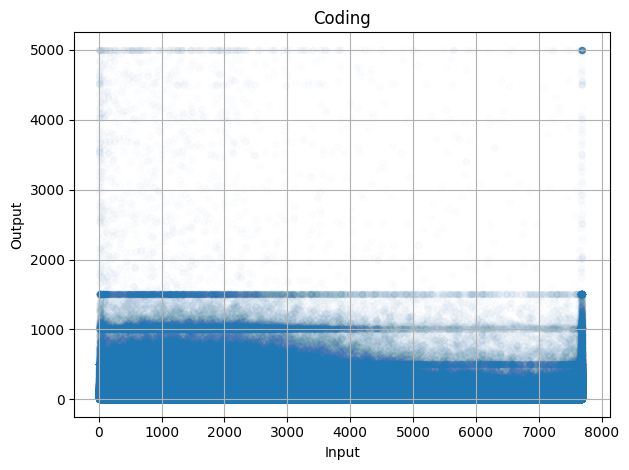

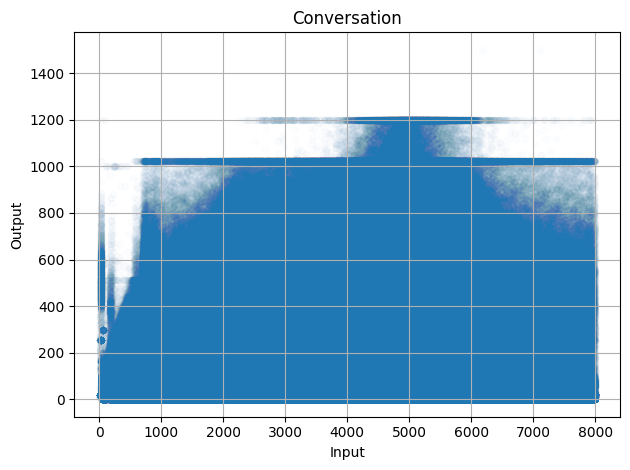

In [14]:
for trace_name, df_trace in df_traces.items():
    df_trace[["ContextTokens", "GeneratedTokens"]].plot.scatter(
        x="ContextTokens",
        y="GeneratedTokens",
        xlabel="Input",
        ylabel="Output",
        alpha=0.01,
        grid=True,
        title=trace_name,
    )
    plt.tight_layout()
    plt.show()

## Analysis over time

In [15]:
def plt_invocations_time(df, figsize=(15, 5)):
    df_copy = df.copy()
    df_copy["Time"] = df_copy["TIMESTAMP"].dt.round(freq="min")
    df_copy.groupby("Time").count()["TIMESTAMP"].plot(
        grid=True,
        ylim=0,
        figsize=figsize
    )
    plt.ylabel("Number of invocations per minute")
    plt.tight_layout()
    plt.show()

In [16]:
def plt_tokens_time(df, field="ContextTokens", label="Input", show=False):
    df_copy = df.copy()
    df_copy["Time"] = df_copy["TIMESTAMP"].dt.round(freq="min")
    df_copy[["Time", field]].groupby("Time").sum()[field].plot(
        grid=True,
        ylim=0,
        label=label,
    )
    plt.ylabel("Number of tokens per minute")
    plt.legend()
    if show:
        plt.show()

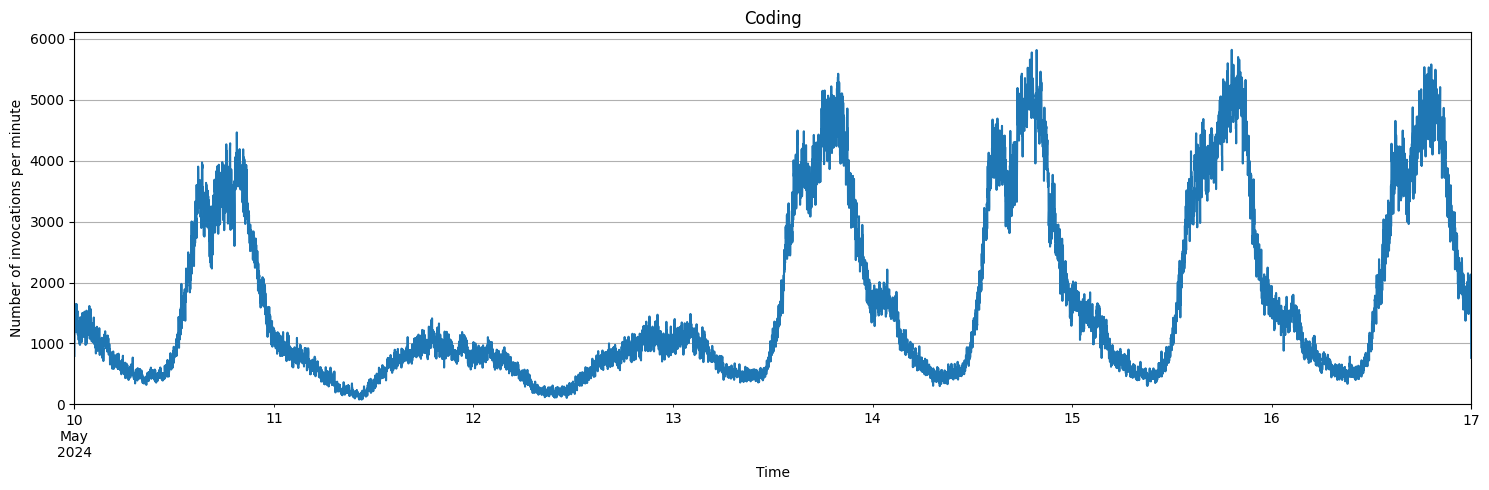

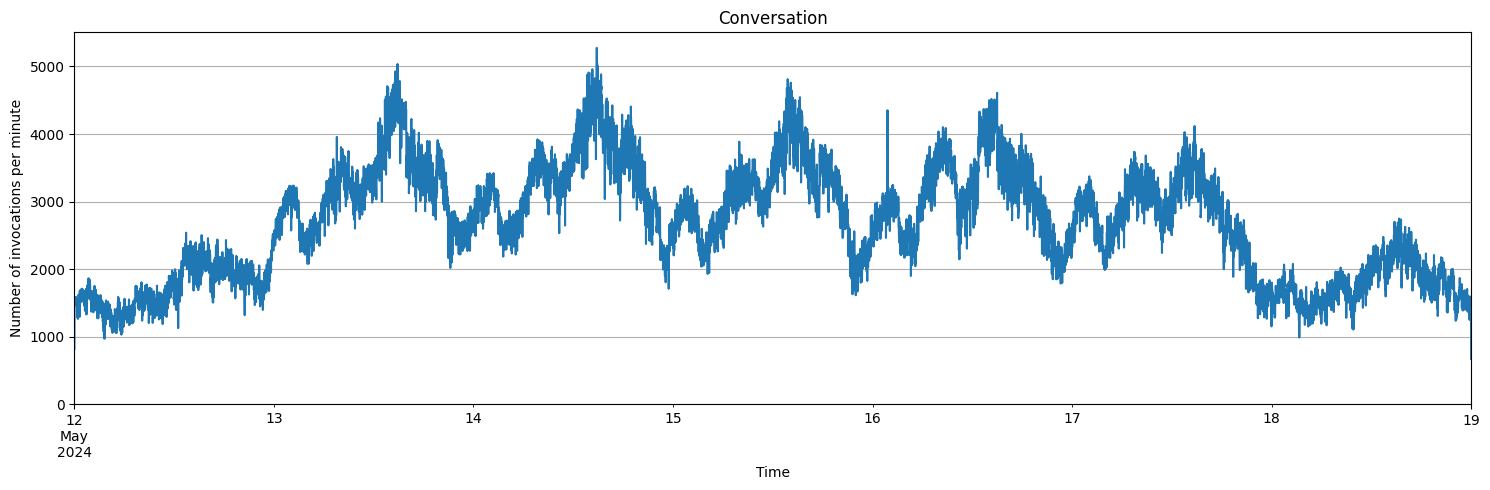

In [17]:
for trace_name, df_trace in df_traces.items():
    plt.title(trace_name)
    plt_invocations_time(df_trace)

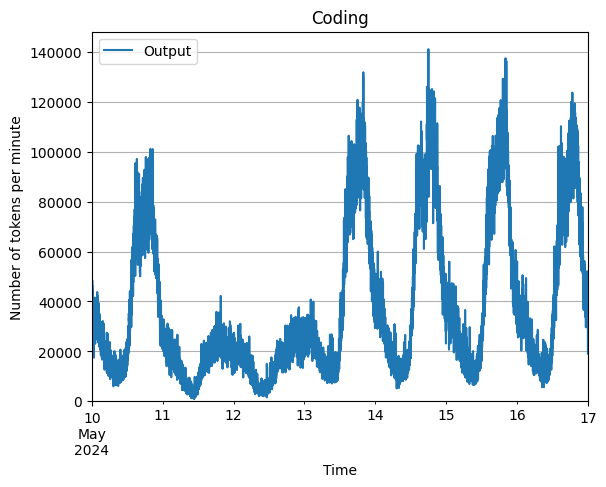

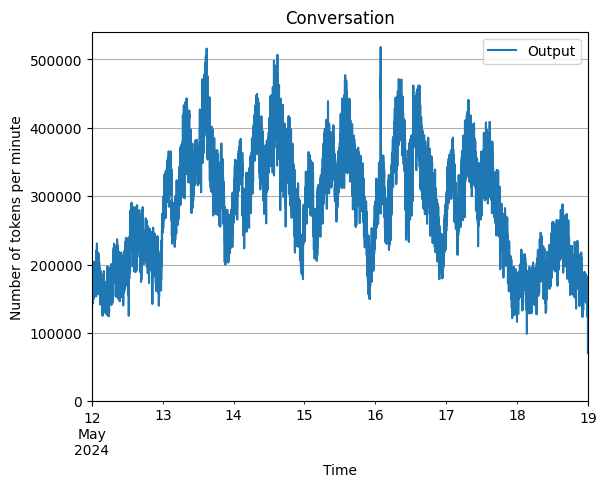

In [ ]:
for trace_name, df_trace in df_traces.items():
    plt.title(trace_name)
    plt_tokens_time(df_trace, "ContextTokens", "Input")
    plt_tokens_time(df_trace, "GeneratedTokens", "Output")
    plt.show()

/home/user/miniconda3/envs/nano-vllm/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


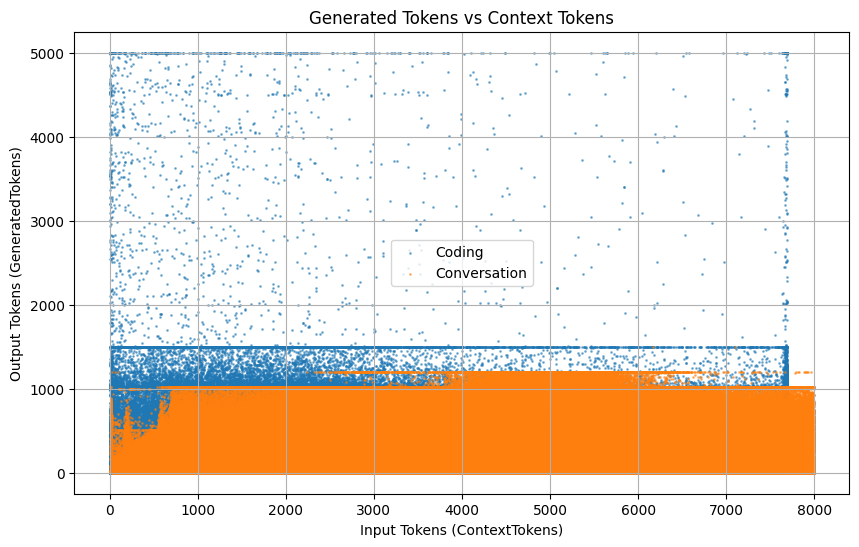

In [25]:

def plot_generated_vs_context_tokens(dfs):
    """
    绘制生成token数量与输入token数量的关系图
    """
    plt.figure(figsize=(10, 6))
    
    for trace_name, df in dfs.items():
        plt.scatter(df["ContextTokens"], df["GeneratedTokens"], 
                   alpha=0.5, label=trace_name, s=1)
    
    plt.xlabel("Input Tokens (ContextTokens)")
    plt.ylabel("Output Tokens (GeneratedTokens)")
    plt.title("Generated Tokens vs Context Tokens")
    plt.legend()
    plt.grid(True)
    plt.show()

# 使用该函数绘制图表
plot_generated_vs_context_tokens(df_traces)

In [ ]:

def plot_correlation_heatmap(dfs):
    """
    为每个trace绘制ContextTokens和GeneratedTokens之间的相关性热力图
    """
    fig, axes = plt.subplots(1, len(dfs), figsize=(5*len(dfs), 5))
    if len(dfs) == 1:
        axes = [axes]
    
    for idx, (trace_name, df) in enumerate(dfs.items()):
        # 计算相关系数
        correlation = df["ContextTokens"].corr(df["GeneratedTokens"])
        
        # 创建散点图
        axes[idx].scatter(df["ContextTokens"], df["GeneratedTokens"], alpha=0.5, s=1)
        axes[idx].set_xlabel("Input Tokens (ContextTokens)")
        axes[idx].set_ylabel("Output Tokens (GeneratedTokens)")
        axes[idx].set_title(f"{trace_name}\nCorrelation: {correlation:.3f}")
        axes[idx].grid(True)
    
    plt.tight_layout()
    plt.show()

# 使用该函数绘制相关性图
plot_correlation_heatmap(df_traces)

Plotting dual axis chart for Coding


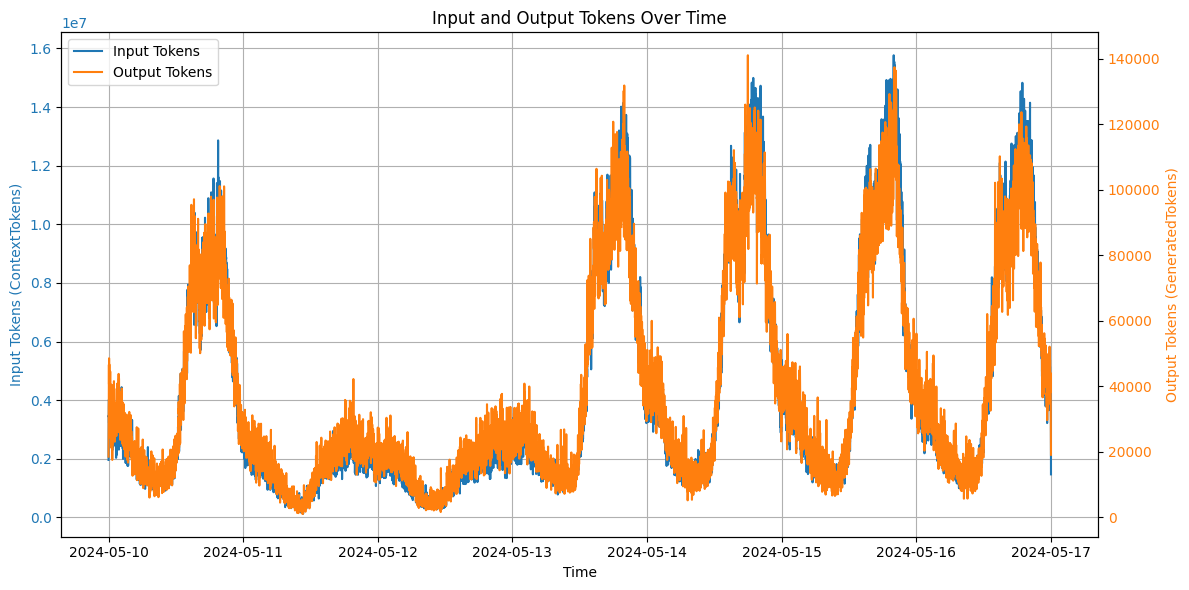

Plotting dual axis chart for Conversation


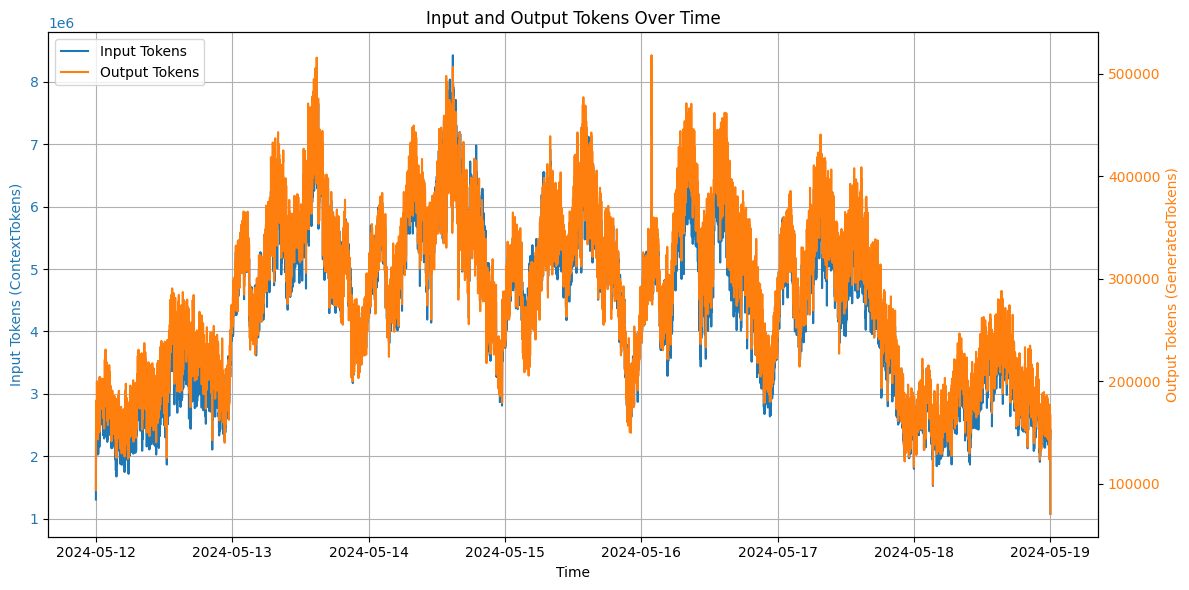

In [26]:

def plt_tokens_time_dual_axis(df, show=False):
    """
    在同一个图中使用双Y轴绘制输入和输出token数量
    左侧Y轴显示输入token数量，右侧Y轴显示输出token数量
    """
    df_copy = df.copy()
    df_copy["Time"] = df_copy["TIMESTAMP"].dt.round(freq="min")
    
    # 按时间聚合数据
    input_data = df_copy[["Time", "ContextTokens"]].groupby("Time").sum()["ContextTokens"]
    output_data = df_copy[["Time", "GeneratedTokens"]].groupby("Time").sum()["GeneratedTokens"]
    
    # 创建图形和轴
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # 绘制输入token（左Y轴）
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Input Tokens (ContextTokens)', color=color)
    ax1.plot(input_data.index, input_data.values, color=color, label='Input Tokens')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)
    
    # 创建共享X轴的第二个Y轴
    ax2 = ax1.twinx()
    
    # 绘制输出token（右Y轴）
    color = 'tab:orange'
    ax2.set_ylabel('Output Tokens (GeneratedTokens)', color=color)
    ax2.plot(output_data.index, output_data.values, color=color, label='Output Tokens')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # 添加图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title('Input and Output Tokens Over Time')
    plt.tight_layout()
    
    if show:
        plt.show()

# 使用示例（对每个trace绘制图表）：
for trace_name, df_trace in df_traces.items():
    print(f"Plotting dual axis chart for {trace_name}")
    plt_tokens_time_dual_axis(df_trace, show=True)

Plotting request rate and tokens charts for Coding


/tmp/ipykernel_1248666/2522523167.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  grouped = df_copy.groupby(pd.Grouper(key='Time', freq=window))


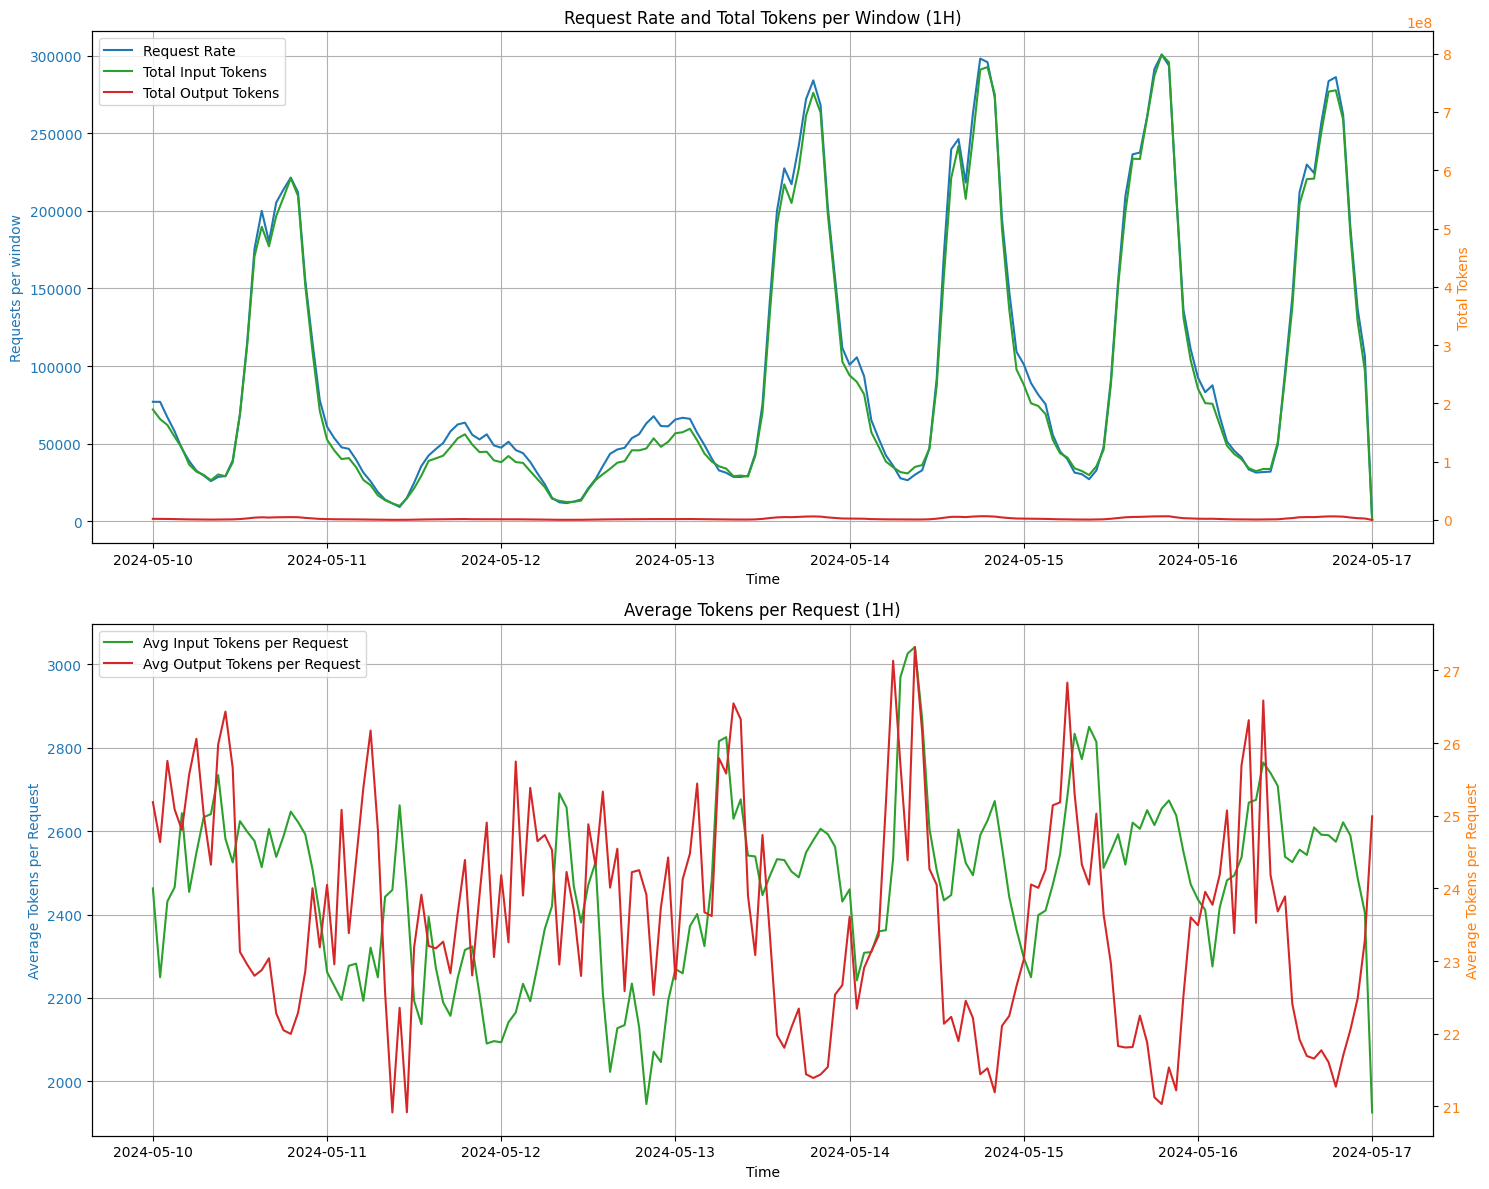

Plotting request rate and tokens charts for Conversation


/tmp/ipykernel_1248666/2522523167.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  grouped = df_copy.groupby(pd.Grouper(key='Time', freq=window))


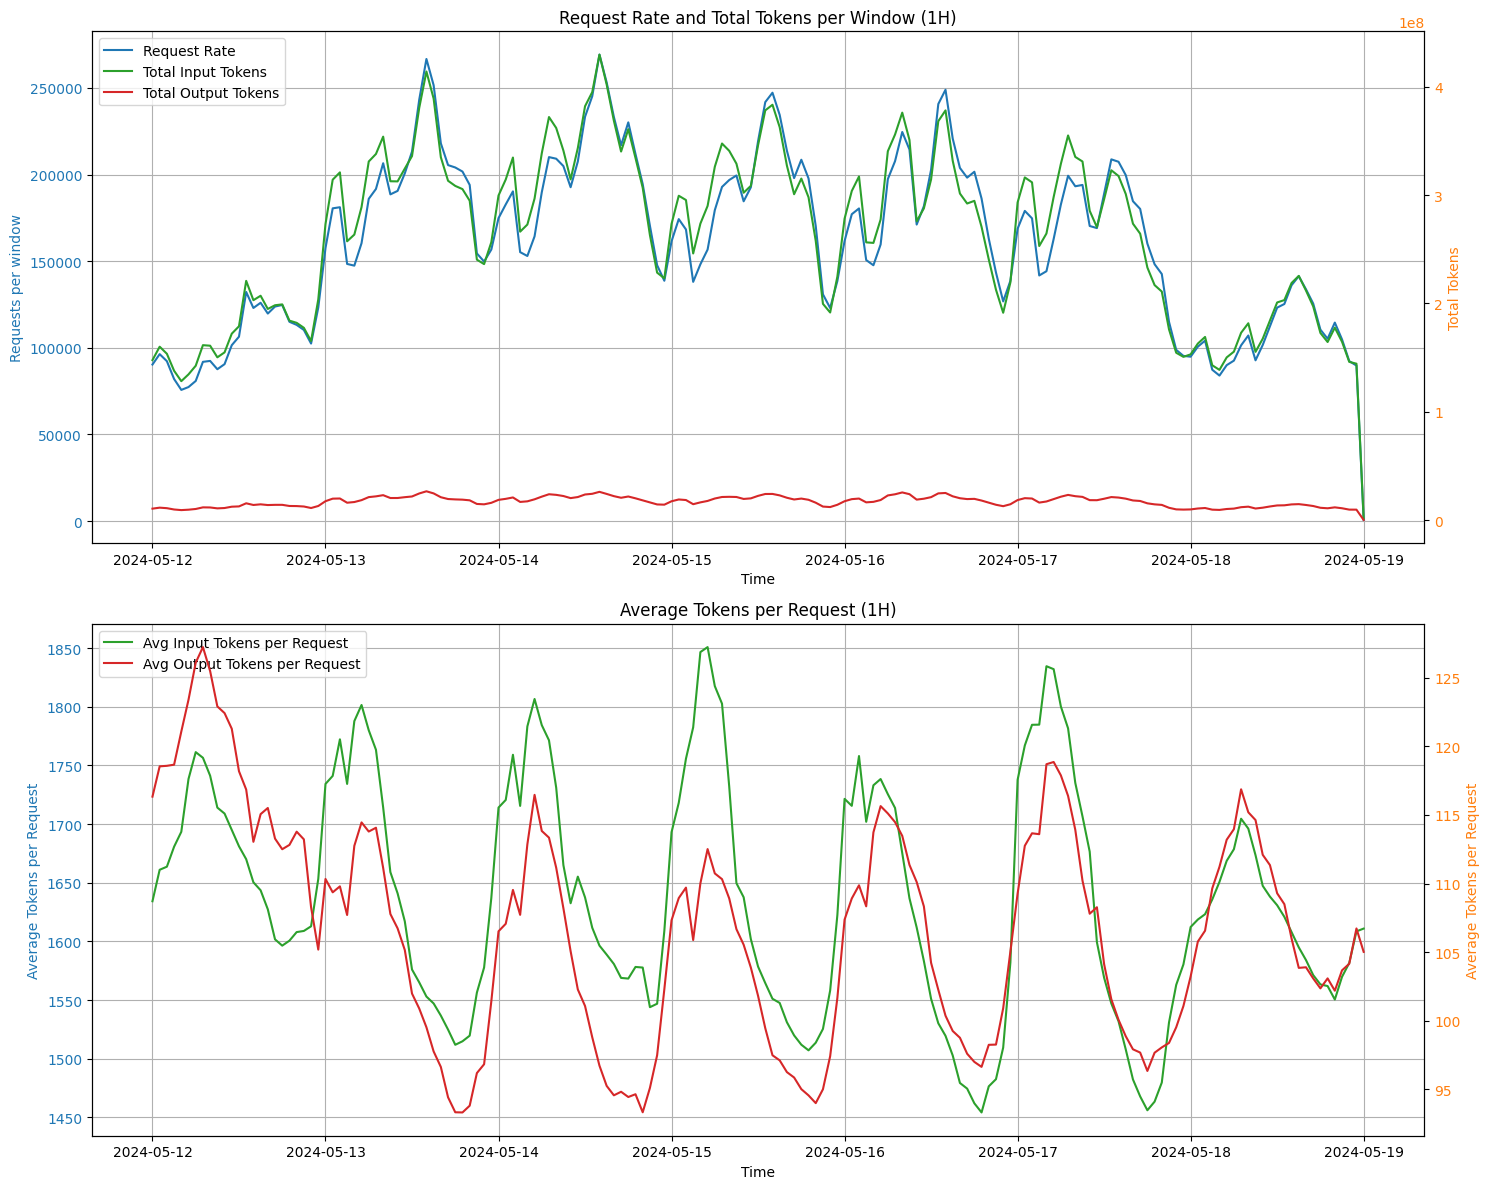

In [27]:

def plot_request_rate_and_tokens_dual_axis(df, window='1H', show=False):
    """
    创建两个双Y轴图表：
    1. 上图：请求到达率（每分钟请求数）和总输入/输出token数
    2. 下图：平均每请求的输入/输出token数
    
    参数:
    - df: 数据框
    - window: 时间窗口大小，默认为1小时 ('1H')
    - show: 是否显示图表
    """
    df_copy = df.copy()
    df_copy["Time"] = df_copy["TIMESTAMP"].dt.round(freq="min")
    
    # 按时间窗口聚合数据
    grouped = df_copy.groupby(pd.Grouper(key='Time', freq=window))
    
    # 计算请求速率（每窗口请求数）
    request_rate = grouped.size()
    
    # 计算总token数
    total_input_tokens = grouped["ContextTokens"].sum()
    total_output_tokens = grouped["GeneratedTokens"].sum()
    
    # 计算平均每请求token数
    avg_input_tokens = grouped["ContextTokens"].mean()
    avg_output_tokens = grouped["GeneratedTokens"].mean()
    
    # 创建两个子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # 第一个图：请求速率和总token数
    color1 = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Requests per window', color=color1)
    ax1.plot(request_rate.index, request_rate.values, color=color1, label='Request Rate')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True)
    
    ax1_twin = ax1.twinx()
    color2 = 'tab:orange'
    ax1_twin.set_ylabel('Total Tokens', color=color2)
    ax1_twin.plot(total_input_tokens.index, total_input_tokens.values, 
                  color='tab:green', label='Total Input Tokens')
    ax1_twin.plot(total_output_tokens.index, total_output_tokens.values, 
                  color='tab:red', label='Total Output Tokens')
    ax1_twin.tick_params(axis='y', labelcolor=color2)
    
    # 合并图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    ax1.set_title(f'Request Rate and Total Tokens per Window ({window})')
    
    # 第二个图：平均每请求的token数
    color3 = 'tab:blue'
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Average Tokens per Request', color=color3)
    ax2.plot(avg_input_tokens.index, avg_input_tokens.values, 
             color='tab:green', label='Avg Input Tokens per Request')
    ax2.tick_params(axis='y', labelcolor=color3)
    ax2.grid(True)
    
    ax2_twin = ax2.twinx()
    color4 = 'tab:orange'
    ax2_twin.set_ylabel('Average Tokens per Request', color=color4)
    ax2_twin.plot(avg_output_tokens.index, avg_output_tokens.values, 
                  color='tab:red', label='Avg Output Tokens per Request')
    ax2_twin.tick_params(axis='y', labelcolor=color4)
    
    # 合并图例
    lines3, labels3 = ax2.get_legend_handles_labels()
    lines4, labels4 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines3 + lines4, labels3 + labels4, loc='upper left')
    
    ax2.set_title(f'Average Tokens per Request ({window})')
    
    plt.tight_layout()
    
    if show:
        plt.show()

# 使用示例（对每个trace绘制图表）：
for trace_name, df_trace in df_traces.items():
    print(f"Plotting request rate and tokens charts for {trace_name}")
    plot_request_rate_and_tokens_dual_axis(df_trace, window='1H', show=True)